# Part 7a: Bitstream Generation
_Completed_

In the previous sections we've seen how to train a Neural Network with a small resource footprint using QKeras, then to convert it to `hls4ml` and create an IP. That IP can be interfaced into a larger design to deploy on an FPGA device. In this section, we introduce the `VivadoAccelerator` backend of `hls4ml`, where we can easily target some supported devices to get up and running quickly. Specifically, we'll deploy the model on a [pynq-z2 board](http://www.pynq.io/).

In [1]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2024-01-26 17:31:27.475350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load model
Load the model from `part4: quantization` (note you need to have trained the model in part 4 first)

In [2]:
model = load_model('model_3/KERAS_check_best_model.h5', custom_objects=co)

2024-01-26 17:31:29.689935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Convert to hls4ml
We'll convert our model into `hls4ml`, with a few small changes compared to the previous use of the same model in part 4.
We target  `backend='VivadoAccelerator'` backend: this will wrap the HLS NN model, providing an AXI-Stream interface to our IP. We also specify `board='pynq-z2'`.

The pynq-z2 board is a popular board with a Zynq 7020 SoC. Since this device is much smaller than the Alveo we specified in previous sections, we set the `ReuseFactor` of all the `Dense` layers of the model to 64.

In [3]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
for layer in ['fc1', 'fc2', 'fc3', 'output']:
    config['LayerName'][layer]['ReuseFactor'] = 64
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_3/hls4ml_prj_pynq', backend='VivadoAccelerator', board='pynq-z2'
)
hls_model.compile()

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/dsk/l1/misc/fgias/miniforge3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Late

Done


We can see which boards are supported in the [documentation](https://fastmachinelearning.org/hls4ml/advanced/accelerator.html). The `VivadoAccelerator` backend introduces the `AcceleratorConfig` section of configuration. Here we can change some details of the interface to the accelerator IP.


The `create_initial_config` method (of any backend) can be used to create a template dictionary with the default parameters that you can use as a starting point. In the conversion above, we didn't change any of these settings so all the defaults are used.

In [4]:
plotting.print_dict(hls4ml.backends.get_backend('VivadoAccelerator').create_initial_config())

Part:                xcvu13p-flga2577-2-e
ClockPeriod:         5
IOType:              io_parallel
HLSConfig
AcceleratorConfig
  Board:             pynq-z2
  Interface:         axi_stream
  Driver:            python
  Precision
    Input:           float
    Output:          float


## Predict
Run the CPU emulation of the hls4ml NN and save the file to compare against the hardware result later.

In [5]:
import numpy as np

X_test = np.load('X_test.npy')
y_hls = hls_model.predict(np.ascontiguousarray(X_test))
np.save('model_3/y_hls.npy', y_hls) # Use .npy to save numpy arrays to disk

## Synthesize and make bitfile

Now we will synthesize the model, export the IP, and create a bitfile! The `VivadoAccelerator` backend design scripts create a Block Design in Vivado IPI containing our Neural Network IP, as well as the other necessary IPs to create a complete system.

In the case of our `pynq-z2`, we add a DMA IP to transfer data between the PS and PL containg the Neural Network. If you want to create a different design, for example to connect your NN to a sensor, you can use our block designs as a starting point and add in relevant IP for your use case.

Our block diagram looks like this:

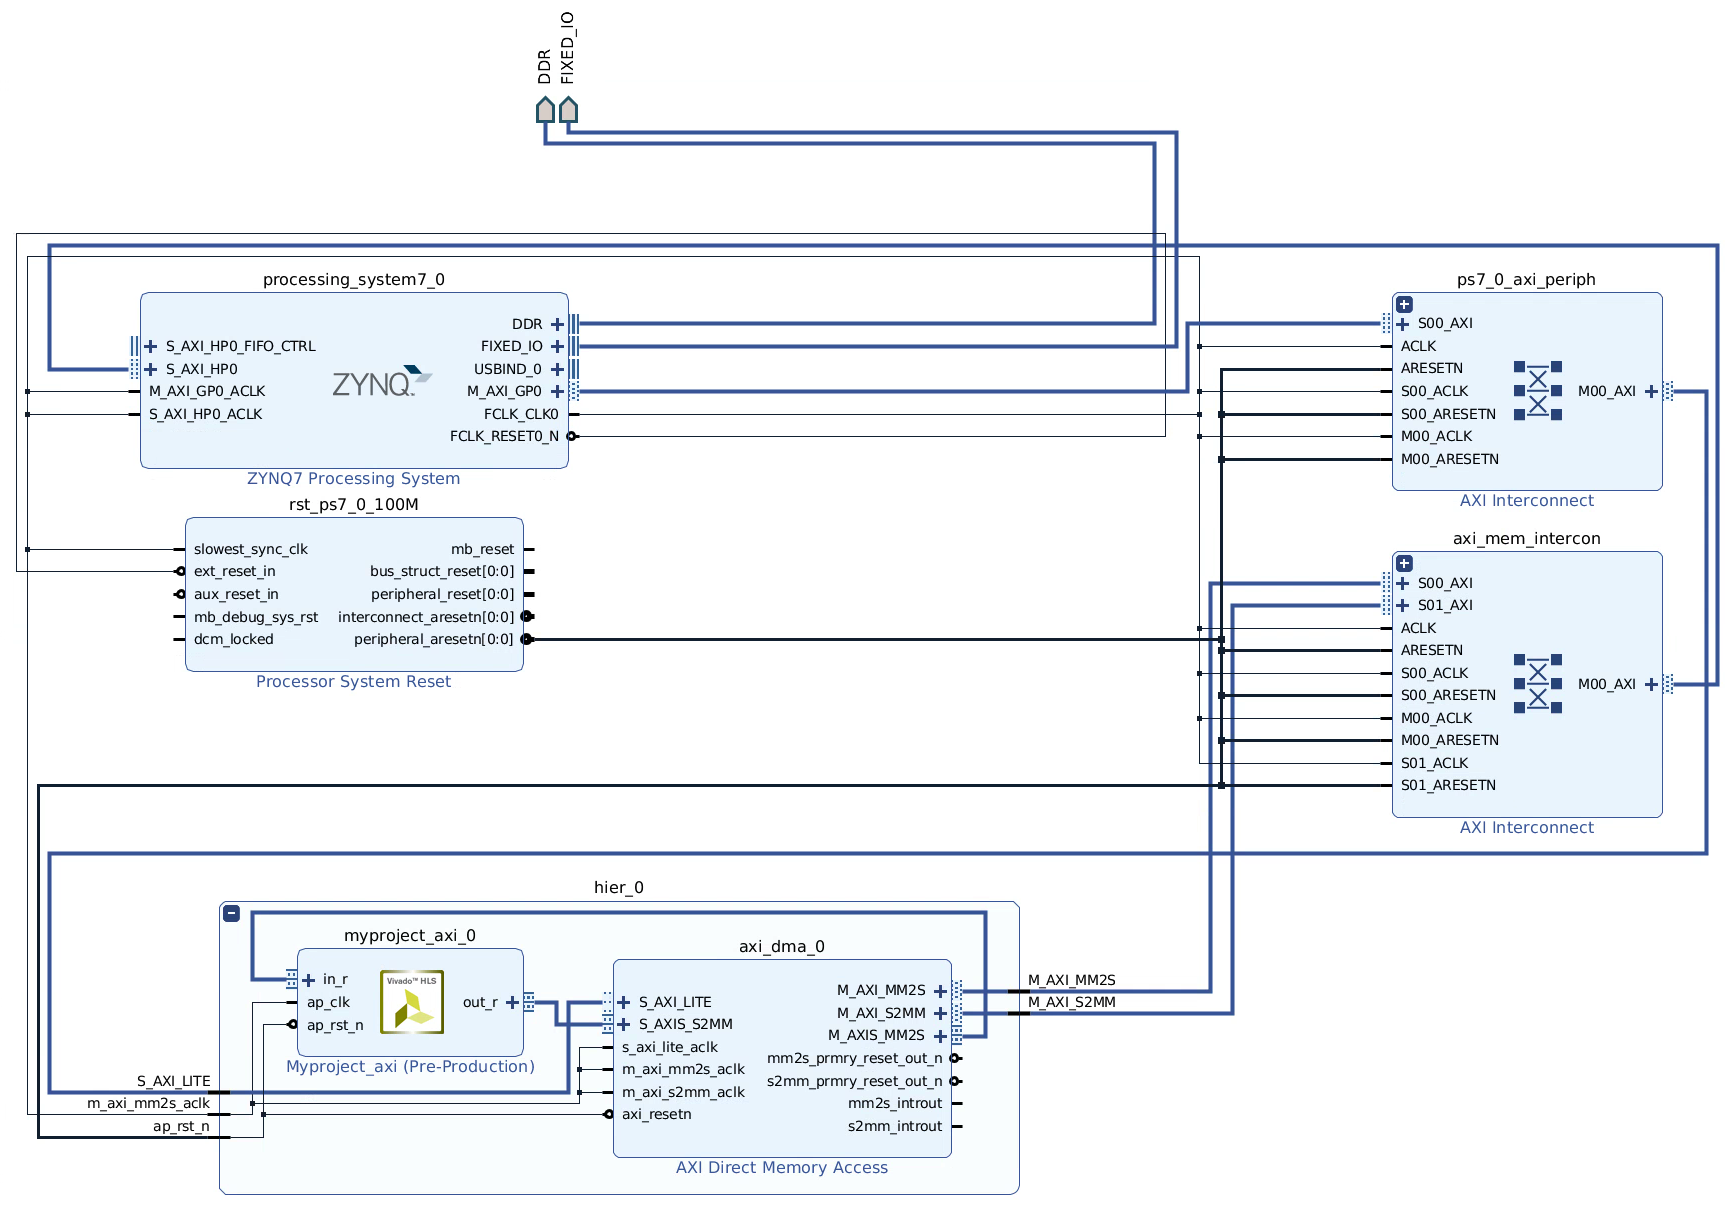

In [6]:
hls_model.build(csim=False, export=True, bitfile=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /users/soft/xilinx/2019.1/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/users/soft/xilinx/2019.1/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'fgias' on host 'bop' (Linux_x86_64 version 3.10.0-1160.62.1.el7.x86_64) on Fri Jan 26 17:34:26 CET 2024
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj_pynq'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj_pynq/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO

INFO: [SYNCHK 200-10] 0 error(s), 1 warning(s).
INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:43 ; elapsed = 00:00:58 . Memory (MB): peak = 988.277 ; gain = 193.551 ; free physical = 2539 ; free virtual = 293730
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config13>' (firmware/nnet_utils/nnet_activation.h:217:46).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, relu_config10>' (firmware/nnet_utils/nnet_activation.h:40:13).
INFO: [XFORM 203

INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:64) in function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Loop-1' (firmware/nnet_utils/nnet_activation.h:43) in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, relu_config4>' completely with a factor of 64.
INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:37) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:40) in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, c

INFO: [XFORM 203-602] Inlining function 'nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::reduce<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 5, nnet::Op_add<ap_fixed<18, 8, (ap_q_mode)5, (ap_o_mode)3, 0> > >' (firmware/nnet_utils/nnet_common.h:45) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 5, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' into 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config13>' (firmware/nnet_utils/nnet_activation.h:239) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::softmax_idx_from_real_val<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config13>' into 'nnet::softmax_stable<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config13>' (firmware/nnet_utils/nnet_activation.h:254

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:57) by setting 'biases[8].V' to 'b8.V.8'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:57) by setting 'biases[9].V' to 'b8.V.9'.
INFO: [X

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:57) by setting 'biases[25].V' to 'b8.V.25'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:49) by setting 'biases[9].V' to 'b5.V.9'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:49) by setting 'biases[10].V' to 'b5.V.10'

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/myproject.cpp:49) by setting 'biases[25].V' to 'b5.V.25'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[11].V' to 'b2.V.11'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[12].V' to 'b2.V.12'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[29].V' to 'b2.V.29'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[30].V' to 'b2

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[45].V' to 'b2.V.45'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[59].V' to 'b2.V.59'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:05:24 ; elapsed = 00:05:52 . Memory (MB): peak = 5194.758 ; gain = 4400.031 ; free physical = 2311 ; free virtual = 291512
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject_axi' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II = 64, Final II = 10, Depth = 10.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 354.96 seconds; current allocated memory: 364.165 MB.
INFO: [BIND 205-100] St

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 4.51 seconds; current allocated memory: 412.725 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_ap_ufixed_ap_fixed_16_6_5_3_0_config11_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_ufixed,ap_fixed<16,6,5,3,0>,config11>.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 64, Final II = 3, Depth = 3.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 2.09 seconds; current allocated memory: 413.953 MB.
I

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'myproject'.
INFO: [HLS 200-111]  Elapsed time: 12.83 seconds; current allocated memory: 632.409 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'myproject_axi' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/in_data' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/in_last_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/out_data' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on po

INFO: [Ipptcl 7-1463] No Compatible Board Interface found. Board Tab not created in customize GUI
Slave segment </axi_dma_0/S_AXI_LITE/Reg> is being mapped into address space </processing_system7_0/Data> at <0x4040_0000 [ 64K ]>
# apply_bd_automation -rule xilinx.com:bd_rule:axi4 -config { Clk_master {Auto} Clk_slave {Auto} Clk_xbar {Auto} Master {/axi_dma_0/M_AXI_MM2S} Slave {/processing_system7_0/S_AXI_HP0} ddr_seg {Auto} intc_ip {New AXI Interconnect} master_apm {0}}  [get_bd_intf_pins processing_system7_0/S_AXI_HP0]
Slave segment </processing_system7_0/S_AXI_HP0/HP0_DDR_LOWOCM> is being mapped into address space </axi_dma_0/Data_MM2S> at <0x0000_0000 [ 512M ]>
# endgroup
# apply_bd_automation -rule xilinx.com:bd_rule:axi4 -config { Clk_master {Auto} Clk_slave {/processing_system7_0/FCLK_CLK0 (100 MHz)} Clk_xbar {/processing_system7_0/FCLK_CLK0 (100 MHz)} Master {/axi_dma_0/M_AXI_S2MM} Slave {/processing_system7_0/S_AXI_HP0} ddr_seg {Auto} intc_ip {/axi_mem_intercon} master_apm {0}}

INFO: [BD 41-1029] Generation completed for the IP Integrator block axi_mem_intercon/s00_couplers/auto_us .
INFO: [BD 41-1029] Generation completed for the IP Integrator block axi_mem_intercon/s01_couplers/auto_us .
INFO: [BD 41-1029] Generation completed for the IP Integrator block axi_mem_intercon/m00_couplers/auto_pc .
INFO: [BD 41-1029] Generation completed for the IP Integrator block hier_0/axi_dma_0 .
INFO: [BD 41-1029] Generation completed for the IP Integrator block hier_0/myproject_axi_0 .
Exporting to file /users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh
Generated Block Design Tcl file /users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1_bd.tcl
Generated Hardware Definition File /users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj_pynq/myproject

Parsing XDC File [/users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/ip/design_1_processing_system7_0_0/design_1_processing_system7_0_0.xdc] for cell 'design_1_i/processing_system7_0/inst'
Finished Parsing XDC File [/users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/ip/design_1_processing_system7_0_0/design_1_processing_system7_0_0.xdc] for cell 'design_1_i/processing_system7_0/inst'
Parsing XDC File [/users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/ip/design_1_rst_ps7_0_100M_0/design_1_rst_ps7_0_100M_0_board.xdc] for cell 'design_1_i/rst_ps7_0_100M/U0'
Finished Parsing XDC File [/users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/ip/desig

Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00.01 . Memory (MB): peak = 2717.102 ; gain = 0.000 ; free physical = 6900 ; free virtual = 292532
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 6 instances were transformed.
  RAM32M => RAM32M (RAMD32, RAMD32, RAMD32, RAMD32, RAMD32, RAMD32, RAMS32, RAMS32): 5 instances
  RAM32X1D => RAM32X1D (RAMD32, RAMD32): 1 instances

20 Infos, 3 Warnings, 0 Critical Warnings and 0 Errors encountered.
link_design completed successfully
link_design: Time (s): cpu = 00:00:26 ; elapsed = 00:00:32 . Memory (MB): peak = 2717.102 ; gain = 1186.176 ; free physical = 6900 ; free virtual = 292532
Command: opt_design
Attempting to get a license for feature 'Implementation' and/or device 'xc7z020'
INFO: [Common 17-349] Got license for feature 'Implementation' and/or device 'xc7z020'
Running DRC as a precondition to command opt_design

Starting DRC Task
INFO: [DRC 23-27] Running DRC with 8 threads
INFO: [Project 1-461

INFO: [Common 17-1381] The checkpoint '/users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_opt.dcp' has been generated.
write_checkpoint: Time (s): cpu = 00:00:11 ; elapsed = 00:00:10 . Memory (MB): peak = 3054.531 ; gain = 0.000 ; free physical = 6715 ; free virtual = 292357
INFO: [runtcl-4] Executing : report_drc -file design_1_wrapper_drc_opted.rpt -pb design_1_wrapper_drc_opted.pb -rpx design_1_wrapper_drc_opted.rpx
Command: report_drc -file design_1_wrapper_drc_opted.rpt -pb design_1_wrapper_drc_opted.pb -rpx design_1_wrapper_drc_opted.rpx
INFO: [IP_Flow 19-1839] IP Catalog is up to date.
INFO: [DRC 23-27] Running DRC with 8 threads
INFO: [Coretcl 2-168] The results of DRC are in file /users/cao/fgias/fpga-practicals/hls4ml-tutorial/model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_drc_opted.rpt.
report_drc completed successfully
report_drc: Time (s): 


Phase 4.1.1 Post Placement Optimization
Post Placement Optimization Initialization | Checksum: 121159d21

Phase 4.1.1.1 BUFG Insertion
INFO: [Place 46-33] Processed net design_1_i/hier_0/myproject_axi_0/inst/grp_myproject_fu_234/grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1_fu_44/ap_NS_fsm12_out, BUFG insertion was skipped due to placement/routing conflicts.
INFO: [Place 46-33] Processed net design_1_i/hier_0/myproject_axi_0/inst/grp_myproject_fu_234/grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s_fu_108/ap_NS_fsm10_out, BUFG insertion was skipped due to placement/routing conflicts.
INFO: [Place 46-33] Processed net design_1_i/hier_0/myproject_axi_0/inst/grp_myproject_fu_234/grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1_fu_44/ap_NS_fsm11_out, BUFG insertion was skipped due to placement/routing conflicts.
INFO: [Place 46-33] Processed net design_1_i/hier_0/myproject_axi

 Number of Nodes with overlaps = 723
 Number of Nodes with overlaps = 281
 Number of Nodes with overlaps = 109
 Number of Nodes with overlaps = 39
 Number of Nodes with overlaps = 21
 Number of Nodes with overlaps = 18
 Number of Nodes with overlaps = 10
 Number of Nodes with overlaps = 1
 Number of Nodes with overlaps = 0
INFO: [Route 35-416] Intermediate Timing Summary | WNS=0.370  | TNS=0.000  | WHS=N/A    | THS=N/A    |

Phase 4.1 Global Iteration 0 | Checksum: 17e6c4c24

Time (s): cpu = 00:01:55 ; elapsed = 00:00:51 . Memory (MB): peak = 3134.570 ; gain = 0.000 ; free physical = 6318 ; free virtual = 291979

Phase 4.2 Global Iteration 1
 Number of Nodes with overlaps = 51
 Number of Nodes with overlaps = 61
 Number of Nodes with overlaps = 55
 Number of Nodes with overlaps = 38
 Number of Nodes with overlaps = 10
 Number of Nodes with overlaps = 6
 Number of Nodes with overlaps = 2
 Number of Nodes with overlaps = 14
 Number of Nodes with overlaps = 1
 Number of Nodes with overlap

INFO: [Timing 38-35] Done setting XDC timing constraints.
Running Vector-less Activity Propagation...

Finished Running Vector-less Activity Propagation
Resolution: To review and fix problems, please run Power Constraints Advisor in the GUI from Tools > Power Constraints Advisor or run report_power with the -advisory option to generate a text report.
111 Infos, 4 Warnings, 0 Critical Warnings and 0 Errors encountered.
report_power completed successfully
report_power: Time (s): cpu = 00:00:14 ; elapsed = 00:00:08 . Memory (MB): peak = 3276.586 ; gain = 0.000 ; free physical = 6266 ; free virtual = 291957
INFO: [runtcl-4] Executing : report_route_status -file design_1_wrapper_route_status.rpt -pb design_1_wrapper_route_status.pb
INFO: [runtcl-4] Executing : report_timing_summary -max_paths 10 -file design_1_wrapper_timing_summary_routed.rpt -pb design_1_wrapper_timing_summary_routed.pb -rpx design_1_wrapper_timing_summary_routed.rpx -warn_on_violation 
INFO: [Timing 38-91] UpdateTimingPa

INFO: [Designutils 20-2272] Running write_bitstream with 8 threads.
Loading data files...
Loading site data...
Loading route data...
Processing options...
Creating bitmap...
Creating bitstream...
Writing bitstream ./design_1_wrapper.bit...
INFO: [Vivado 12-1842] Bitgen Completed Successfully.
INFO: [Project 1-120] WebTalk data collection is mandatory when using a WebPACK part without a full Vivado license. To see the specific WebTalk data collected for your design, open the usage_statistics_webtalk.html or usage_statistics_webtalk.xml file in the implementation directory.
INFO: [Common 17-83] Releasing license: Implementation
133 Infos, 17 Warnings, 0 Critical Warnings and 0 Errors encountered.
write_bitstream completed successfully
write_bitstream: Time (s): cpu = 00:00:38 ; elapsed = 00:00:35 . Memory (MB): peak = 3548.672 ; gain = 272.086 ; free physical = 6214 ; free virtual = 291917
INFO: [Common 17-206] Exiting Vivado at Fri Jan 26 17:57:18 2024...
[Fri Jan 26 17:57:23 2024] impl

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.367',
  'BestLatency': '92',
  'WorstLatency': '92',
  'IntervalMin': '93',
  'IntervalMax': '93',
  'BRAM_18K': '4',
  'DSP': '9',
  'FF': '21355',
  'LUT': '40847',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'},
 'TimingReport': {'WNS': 0.371,
  'TNS': 0.0,
  'WHS': 0.016,
  'THS': 0.0,
  'WPWS': 3.75,
  'TPWS': 0.0}}

The floorplan of our NN placed on the `pynq-z2` is shown below, with the hls4ml Neural Network highlighted in purple. You can reproduce this yourself if running the tutorial with a local Vivado installation by opening the project at `model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.xpr` in the Vivado GUI and clicking "Open Implemented Design".



Let's also inspect the final resource usage after placement:

In [7]:
!sed -n '30,45p' model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_utilization_placed.rpt


+----------------------------+-------+-------+-----------+-------+
|          Site Type         |  Used | Fixed | Available | Util% |
+----------------------------+-------+-------+-----------+-------+
| Slice LUTs                 | 20080 |     0 |     53200 | 37.74 |
|   LUT as Logic             | 19790 |     0 |     53200 | 37.20 |
|   LUT as Memory            |   290 |     0 |     17400 |  1.67 |
|     LUT as Distributed RAM |    22 |     0 |           |       |
|     LUT as Shift Register  |   268 |     0 |           |       |
| Slice Registers            | 21527 |     0 |    106400 | 20.23 |
|   Register as Flip Flop    | 21527 |     0 |    106400 | 20.23 |
|   Register as Latch        |     0 |     0 |    106400 |  0.00 |
| F7 Muxes                   |    15 |     0 |     26600 |  0.06 |
| F8 Muxes                   |     1 |     0 |     13300 | <0.01 |
+----------------------------+-------+-------+-----------+-------+



## Preparations for deployment
First, you'll need to follow the [setup instructions for the pynq-z2 board](https://pynq.readthedocs.io/en/latest/getting_started/pynq_z2_setup.html).
Typically, this includes connecting the board to your host via ethernet and setting up a static IP address for your host (192.168.2.1). 
The IP address for the pynq-z2 is 192.168.2.99.
The default username and password is `xilinx`.

Next you'll transfer the following files from the earlier part of this notebook into a directory on the pynq-z2:
- **bitfile**: `model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper.bit` -> `hls4ml_nn.bit`
- **hardware handoff**: `model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh` -> `hls4ml_nn.hwh`
- **driver**: `model_3/hls4ml_prj_pynq/axi_stream_driver.py` -> `axi_stream_driver.py`
- **data**: `X_test.npy`, `y_test.npy`
- **notebook**: `part7b_deployment.ipynb`

The following commands archive these files into `model_3/hls4ml_prj_pynq/package.tar.gz` that can be copied over to the pynq-z2 and extracted.

In [1]:
!mkdir -p model_3/hls4ml_prj_pynq/package
!cp model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper.bit model_3/hls4ml_prj_pynq/package/hls4ml_nn.bit
!cp model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh model_3/hls4ml_prj_pynq/package/hls4ml_nn.hwh
!cp model_3/hls4ml_prj_pynq/axi_stream_driver.py model_3/hls4ml_prj_pynq/package/
!cp X_test.npy y_test.npy model_3/hls4ml_prj_pynq/package
!cp part7b_deployment.ipynb model_3/hls4ml_prj_pynq/package
!tar -czvf model_3/hls4ml_prj_pynq/package.tar.gz -C model_3/hls4ml_prj_pynq/package/ .

./
./hls4ml_nn.bit
./hls4ml_nn.hwh
./axi_stream_driver.py
./X_test.npy
./y_test.npy
./part7b_deployment.ipynb


To copy it to the pynq-z2 with the default settings, the command would be:

```bash
scp model_3/hls4ml_prj_pynq/package.tar.gz xilinx@192.168.2.99:~/jupyter_notebooks
```

Then you can navigate your web browser to http://192.168.2.99.
You will see the JupyterHub running on the pynq-z2. Open a terminal and extract the tarball.

```bash
cd ~/jupyter_notebooks
tar xvzf package.tar.gz
```

Now open the notebook `part7b_deployment.ipynb` on the pynq-z2 JupyterHub

You can also connect to the board with ssh. 

- Username: `xilinx`
- Password: `xilinx`
- IP: 192.168.2.99

```
ssh xilinx@192.168.2.99
```